In [1]:
# Parameters
backend = "module://matplotlib_inline.backend_inline"


# Parameter Retrieval 2: Timeseries 

This example shows how to use the [rt1 python package](https://github.com/raphaelquast/rt1_model) together with [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) to setup a retrieval procedure to obtain both static and dynamic parameters from a series of incidence-angle dependent $\sigma^0$ measurements.

> **NOTE:** to run this example you need the additional dependencies [matplotlib](https://matplotlib.org/) and [ipympl](https://matplotlib.org/ipympl/).


In [2]:
%matplotlib widget
from rt1_model import RT1, surface, volume, set_loglevel
from scipy.optimize import least_squares
import numpy as np

set_loglevel("info")

## Specify simulation and fit parameters
### Set parameter values that are used to simulate the data

In [3]:
dB, sig0 = True, True

num = 100  # Number of measurements
incs = 30  # Available incidence angles per measurement
noise_sigma = 0.5 if dB is True else 1e-3  # Noise-level (sigma of gaussian noise)

inc = np.random.normal(45, 10, (num, incs)).clip(20, 70)  # Incidence angles
N = np.random.normal(0.25, 0.25, (num, 1)).clip(0.01, 0.5)  # NormBRDF values

sim_params = dict(tau=0.1, omega=0.1, N=N)  # Simulation parameter values
const_params = dict(t_s=0.4)  # Constant parameters (assumed to be known)

### Set start values and boundaries for the fit

In [4]:
start_vals = dict(tau=0.3, omega=0.2, N=[0.3] * num)
bnd_vals = dict(tau=(0.01, 0.5), omega=(0.01, 0.5), N=[(0.01, 0.5)] * num)

## Setup RT1 and create a simulated dataset

In [5]:
V = volume.Isotropic()
SRF = surface.HG_nadirnorm(t="t_s", ncoefs=10)

R = RT1(V=V, SRF=SRF, int_Q=True, dB=dB, sig0=True)
R.NormBRDF = "N"  # Use a synonym for NormBRDF parameter

R.set_geometry(t_0=np.deg2rad(inc), p_0=0, geometry="mono")
R.update_params(**sim_params, **const_params)

tot = R.calc()[0]
tot += np.random.normal(0, noise_sigma, tot.shape)  # Add some random noise

12:44:22.448 INFO: Evaluating coefficients for interaction-term...


12:44:22.531 INFO: Coefficients extracted, it took 0.00789 sec.


## Setup scipy optimize to fit RT1 model to the data

In [6]:
from scipy.sparse import csr_matrix, vstack, block_diag

param_names = list(sim_params)

def parse_params(x):
    """Map 1D parameter array to dict {parameter_name: value(s)}."""
    return dict(tau=x[0], omega=x[1], N=x[2:][:, np.newaxis])


def fun(x):
    """Calculate residuals."""
    R.update_params(**parse_params(x), **const_params)

    # Ravel output because scipy requires 1D arrays
    res = (R.calc()[0] - tot).ravel()
    return res


def jac(x):
    """Calculate jacobian."""
    R.update_params(**parse_params(x), **const_params)
    jac = np.array(R.jacobian(param_list=param_names))

    # Reshape jacobian to fit scipy.optimize requirements
    # (e.g. a 2D matrix of the shape (# measurements, # parameters) where each 
    # column represents the derivatives with respect to the optimized parameter)
    jac_columns = []
    # The first 2 parameters (tau, omega) are affected by all measurements, 
    # so the corresponding columns of the scipy-jacobian are given by the  
    # ravelled rt1-jacobian values.
    jac_columns += csr_matrix(jac[0].ravel())
    jac_columns += csr_matrix(jac[1].ravel())
    # The third parameters (N) represent timeseries of independent variables 
    # (e.g. one value for each timestamp). 
    # Therefore we need to convert the rt1-jacobian into a block-diagonal
    # matrix so that each parameter is only affected by the values 
    # of the corresponding timestamp.
    jac_columns += block_diag(jac[2].tolist(), "csr")
    
    return vstack(jac_columns).T


# Unpack start-values and boundaries as required by scipy optimize
x0 = [start_vals["tau"], start_vals["omega"], *start_vals["N"]]
bounds = list(zip(*[bnd_vals["tau"], bnd_vals["omega"], *bnd_vals["N"]]))

res = least_squares(
    fun=fun,
    x0=x0,
    bounds=bounds,
    jac=jac,
    ftol=1e-8,
    gtol=1e-8,
    xtol=1e-3,
    verbose=2,
)

# Unpack found parameters
found_params = parse_params(res.x)
# Calcuate total backscatter based on found parameters
found_tot = R.calc(**found_params)[0]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.6882e+04                                    8.69e+03    
       1              2         1.3036e+04      2.38e+04       1.47e+00       5.70e+03    
       2              3         3.0041e+03      1.00e+04       4.17e-01       2.78e+03    
       3              4         9.5168e+02      2.05e+03       3.45e-01       1.20e+03    
       4              5         5.1413e+02      4.38e+02       2.57e-01       3.14e+03    
       5              6         3.9051e+02      1.24e+02       1.58e-01       2.08e+03    


       6              7         3.7055e+02      2.00e+01       3.08e-02       1.13e+03    
       7              8         3.6569e+02      4.86e+00       2.80e-03       2.54e+02    
`xtol` termination condition is satisfied.
Function evaluations 8, initial cost 3.6882e+04, final cost 3.6569e+02, first-order optimality 2.54e+02.


## Visualize Results
### Plot timeseries

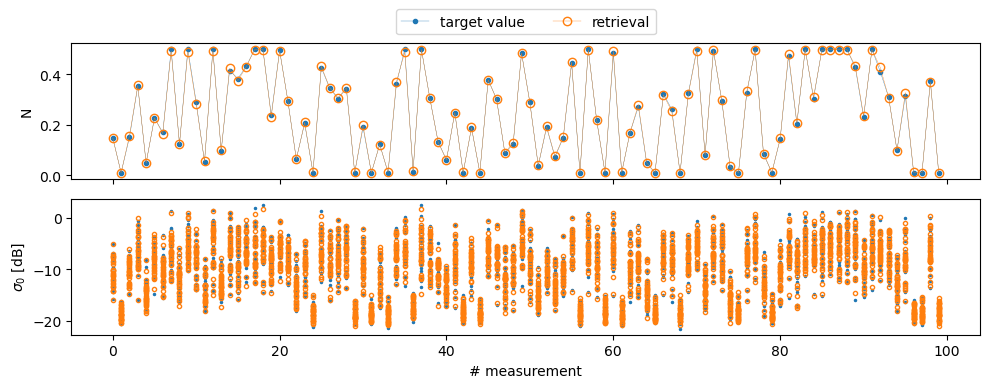

In [7]:
import matplotlib.pyplot as plt

f, (ax, ax2) = plt.subplots(2, figsize=(10, 4), sharex=True)

ax.set_ylabel("N")
ax2.set_ylabel(r"$\sigma_0$ [dB]")
ax2.set_xlabel("# measurement")

ax.plot(sim_params["N"], marker=".", lw=0.25, label="target value")
ax.plot(
    found_params["N"], marker="o", lw=0.25, markerfacecolor="none", label="retrieval"
)

ax2.plot(tot, lw=0, marker=".", c="C0", ms=3)
ax2.plot(found_tot, lw=0, marker="o", markerfacecolor="none", c="C1", ms=3)

ax.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.3))
f.tight_layout()

### Initialize analyzer widget and overlay results

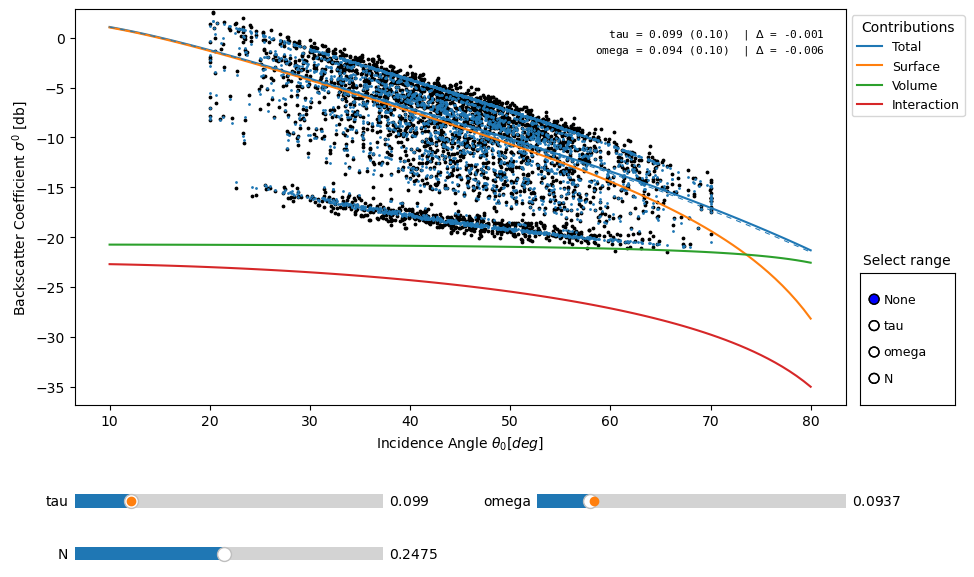

In [8]:
analyze_params = {key: (0.01, 0.5, found_params[key].mean()) for key in param_names}
ana = R.analyze(param_dict=analyze_params)

# Plot fit-data on top
ana.ax.scatter(inc, tot, c="k", s=3, zorder=0)
ana.ax.scatter(inc, found_tot, c="C0", s=1, zorder=0)

# Indicate fit-results in slider-axes
for key, s in ana.sliders.items():
    if key in ["tau", "omega"]:
        s.ax.plot(sim_params[key], np.mean(s.ax.get_ylim()), marker="o")

# Add text for static parameters
t = ana.f.text(
    0.6,
    0.95,
    "\n".join(
        [
            f"{key:>8} = {found_params[key]:.3f} ({sim_params[key]:.2f})  "
            rf"| $\Delta$ = {found_params[key] - sim_params[key]: .3f}"
            for key in ["tau", "omega"]
        ]
    ),
    va="top",
    fontdict=dict(family="monospace", size=8),
)